## Setup
```bash
python3 -m venv .venv084
source .venv084/bin/activate  
pip install -U pip setuptools wheel
pip install pyrosm geopandas shapely fiona pyproj rtree matplotlib jupyterlab ipykernel folium
python -m ipykernel install --user --name=env84 --display-name "Python (env084)"
```

Run Jupyter and change to the relevant Kernel.

In [ ]:
from pathlib import Path
from pyrosm import OSM

# ▶️ Chemin vers ton PBF (à adapter)
PBF_PATH = Path("../osm-data-setup/c084.osm.pbf")
osm = OSM(PBF_PATH.as_posix())
print("Loaded PBF:", PBF_PATH)

#BOUNDS_WIDE  = [4.60, 43.60, 5.90, 44.50]
BOUNDS_TIGHT = [4.70, 43.70, 5.60, 44.40]
print("Using bounds:", BOUNDS_TIGHT)

## Buildings

In [3]:
buildings = osm.get_buildings()
print('Buildings rows:', 0 if buildings is None else len(buildings))
buildings.head() if buildings is not None else None

Buildings rows: 500201


,addr:city,addr:country,addr:full,addr:housenumber,addr:housename,addr:postcode,addr:place,addr:street,email,name,...,source,start_date,wikipedia,id,timestamp,version,tags,osm_type,geometry,changeset
0,Ménerbes,None,None,None,None,None,None,None,None,Église Saint-Luc,...,cadastre-dgi-fr source : Direction Générale de...,None,None,32690142,1715075868,12,"{""check_date"":""2024-05-07"",""denomination"":""cat...",way,"POLYGON ((5.20249 43.83548, 5.2028 43.83553, 5...",NaN
1,None,None,None,None,None,None,None,None,None,La Citadelle,...,cadastre-dgi-fr source : Direction Générale de...,None,None,32690464,1347610728,7,"{""castle_type"":""citadel"",""castle_type:fr"":""cit...",way,"POLYGON ((5.20527 43.83307, 5.20528 43.83307, ...",NaN
2,None,None,None,None,Mairie,None,None,None,None,Mairie de Ménerbes,...,cadastre-dgi-fr source : Direction Générale de...,None,None,32690467,1745241999,11,"{""contact:email"":""contact@menerbes.fr"",""contac...",way,"POLYGON ((5.20419 43.83421, 5.20413 43.83417, ...",NaN
3,None,None,None,None,None,None,None,None,None,Chapelle St Blaise,...,cadastre-dgi-fr source : Direction Générale de...,None,None,32690915,1715077328,6,"{""check_date"":""2024-05-07"",""denomination"":""cat...",way,"POLYGON ((5.20535 43.83261, 5.20532 43.83259, ...",NaN
4,None,None,None,None,None,None,None,None,None,Le Castellet,...,cadastre-dgi-fr source : Direction Générale de...,None,None,32691772,1258913903,4,None,way,"POLYGON ((5.20181 43.83645, 5.202 43.83652, 5....",NaN


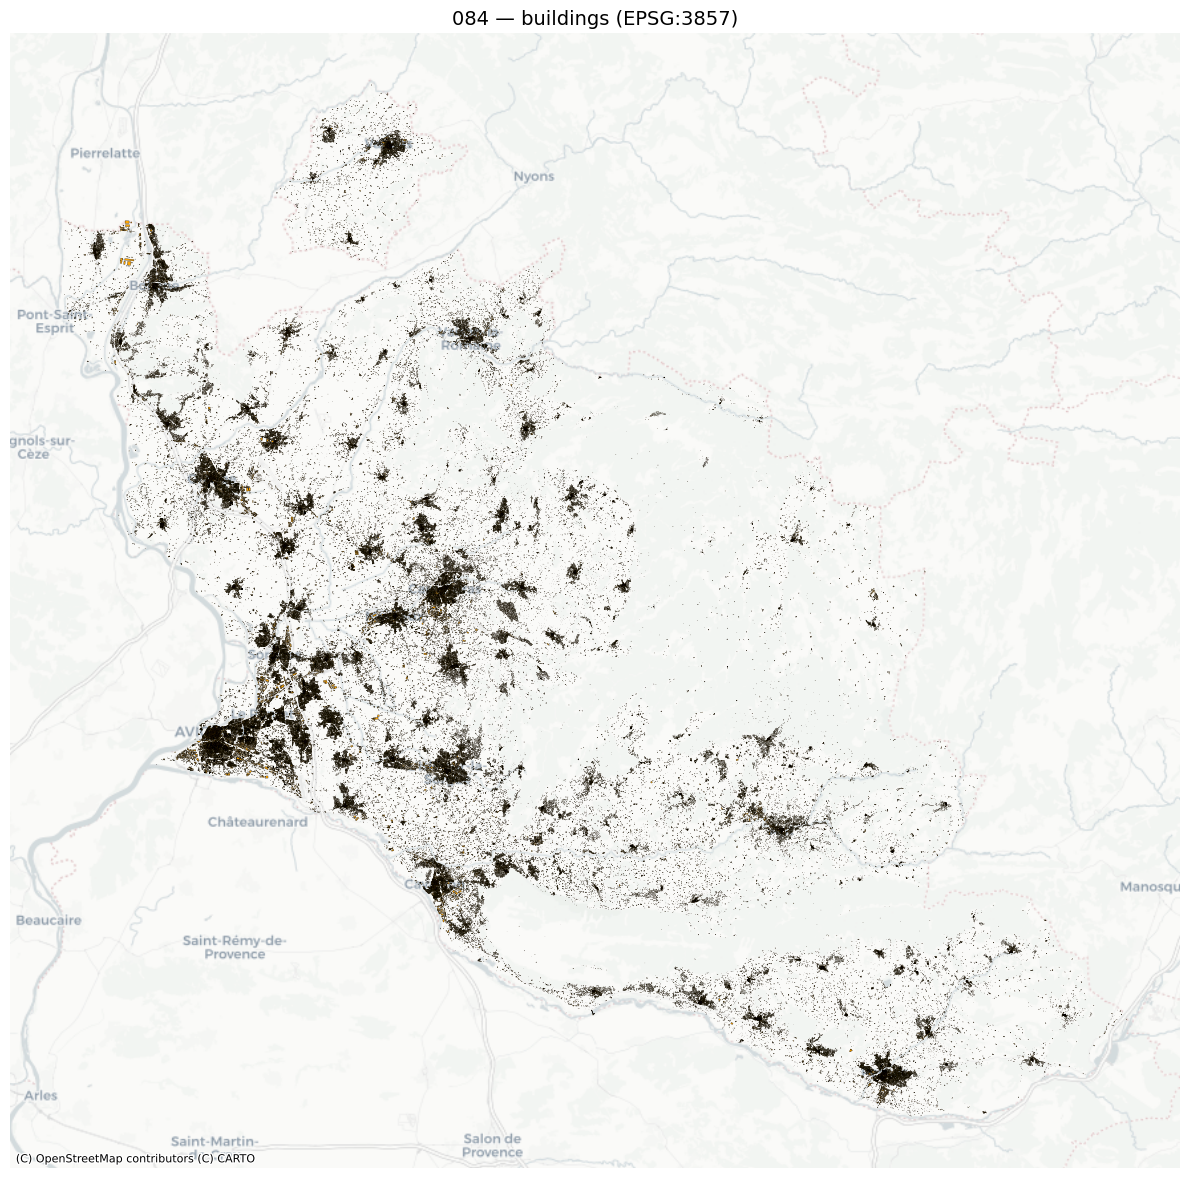

In [6]:
import matplotlib.pyplot as plt
import contextily as ctx

b3857 = buildings.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))

b3857.plot(ax=ax, color="orange", edgecolor="black", linewidth=0.2)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_axis_off()
ax.set_title("084 — buildings (EPSG:3857)", fontsize=14) 
plt.tight_layout()
plt.show()